In [123]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import pandas as pd

from scripts.importing import import_data

from scripts.cleaning import group

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from datetime import datetime, timedelta
pd.set_option('display.max_rows', 50)

In [124]:
# HYPER
AREA = 'MUESED'
RELEASE = 'N1'


In [125]:
df = import_data()


importing data...
end


In [126]:
df.year_release.unique()

array(['2023 N1', '2024 N1', '2022 N2', '2023 N2', '2022 FW', '2022 SS',
       '2022 N1', '2023 SS', '2021 FW', '2021 M1', '2021 AD', '2021 SS',
       '2020 AD', '2020 M1', '2020 SS', '2019 AD', '2019 M2', '2019 SS'],
      dtype=object)

In [127]:

# Function to convert YYYYWW to datetime
def yearweek_to_datetime(yearweek_str):
    yearweek_str = str(yearweek_str)
    year = yearweek_str[:4]
    week = yearweek_str[4:]
    # Parse the year and week and combine it with '0' for Monday
    datetime_str = f'{year} {week} 0'
    # Convert to datetime object, %U is week number of the year, Sunday as the first day of week, 00-53
    # %w is the day of the week, with Sunday as 0
    return pd.to_datetime(datetime_str, format='%Y %U %w')

def filter_dates(row):
    # Extract the year and convert to integer
    year = int(row['year_release'][:4])
    
    if row['release'] == 'N1':
        # Define the start and end dates for the range
        start_date = pd.Timestamp(year=year-1, month=11, day=1)
        end_date = pd.Timestamp(year=year, month=10, day=31)

    elif row['release'] == 'N2':
        start_date = pd.Timestamp(year=year, month=7, day=1)
        end_date = pd.Timestamp(year=year+1, month=6, day=30)
    
    # Check if the year_week is within the range
    return start_date <= row['year_week'] <= end_date


def generate_lux_days_dataframe(start_year, release):
    # Create an empty list to store data
    data = []

    if release == 'N1':
        # Loop through years starting from the input year
        for year in range(start_year, datetime.now().year + 1):
            # Find the last week of November for each year
            last_week_of_november = datetime(year, 11, 30) - timedelta(days=(datetime(year, 11, 30).weekday() + 1) % 7)

            # Generate dates for the last week of November
            for day in range(7):
                current_date = last_week_of_november - timedelta(days=day)
                data.append({'year_week': current_date, 'lux_days': 1})
    
    elif release == 'N2':
        for year in range(start_year, datetime.now().year + 1):
        # Generate dates for the entire month of July
            for day in range(7, 28):
                current_date = datetime(year, 7, day)
                data.append({'year_week': current_date, 'lux_days': 1.5})

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    return df

def linear_interpolation_for_missing_data(df_filtered):
    # Create a complete range of weeks from the start to the end of the original data
    all_weeks_complete = pd.date_range(start=df_filtered['year_week'].min(), end=df_filtered['year_week'].max(), freq='W-SUN')

    # Create a new dataframe with all weeks
    df_full = pd.DataFrame(all_weeks_complete, columns=['year_week'])

    # Merge the original data with the full dataframe
    # This will result in NaNs where the original data is missing
    df_merged = df_full.merge(df_filtered, on='year_week', how='left')

    # Interpolate to fill missing values
    df_merged['order_quantity'] = df_merged['order_quantity'].interpolate(method='linear')
    df_merged = df_merged.fillna(method='ffill')

    return df_merged



    # Function to calculate SMAPE
def smape(y_true, y_pred): 
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def wmape(y_true, y_pred):
    return 100*(np.sum(np.abs(y_pred - y_true)) / np.sum((np.abs(y_true))))



In [128]:
df_temp = df.groupby(by = ['year_week', 'exit', 'brand', 'area_dedalo', 'year_release'], as_index=False)['order_quantity'].sum()

In [129]:
dict_rel = {
    'AD': 'N1',
    'M1': 'N2',
    'M2': 'SS'
}

df_temp['year_release'] = df_temp['year_release'].replace(dict_rel, regex=True)
df_temp['release'] = df_temp['year_release'].str[-2:]

In [130]:
Prophet()

********************
RB
MUESED
N1
********************


/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_17197/125859449.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)


,year_week,exit,brand,area_dedalo,year_release,order_quantity,release
16220,2019-11-03,201910,RB,MUESED,2020 N1,1,N1
16848,2019-11-17,201910,RB,MUESED,2020 N1,2302,N1
17234,2019-11-24,201910,RB,MUESED,2020 N1,5953,N1
17669,2019-12-01,201910,RB,MUESED,2020 N1,3034,N1
18143,2019-12-08,201910,RB,MUESED,2020 N1,5383,N1
...,...,...,...,...,...,...,...
107682,2023-07-30,202301,RB,MUESED,2023 N1,5193,N1
108131,2023-08-06,202301,RB,MUESED,2023 N1,3972,N1
108557,2023-08-13,202301,RB,MUESED,2023 N1,2920,N1
108990,2023-08-20,202301,RB,MUESED,2023 N1,3787,N1


/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_17197/1510168551.py:69: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged = df_merged.fillna(method='ffill')


,year_week,exit,brand,area_dedalo,year_release,order_quantity,release
0,2019-11-03,201910,RB,MUESED,2020 N1,1.0,N1
1,2019-11-10,201910,RB,MUESED,2020 N1,1151.5,N1
2,2019-11-17,201910,RB,MUESED,2020 N1,2302.0,N1
3,2019-11-24,201910,RB,MUESED,2020 N1,5953.0,N1
4,2019-12-01,201910,RB,MUESED,2020 N1,3034.0,N1
...,...,...,...,...,...,...,...
197,2023-07-30,202301,RB,MUESED,2023 N1,5193.0,N1
198,2023-08-06,202301,RB,MUESED,2023 N1,3972.0,N1
199,2023-08-13,202301,RB,MUESED,2023 N1,2920.0,N1
200,2023-08-20,202301,RB,MUESED,2023 N1,3787.0,N1


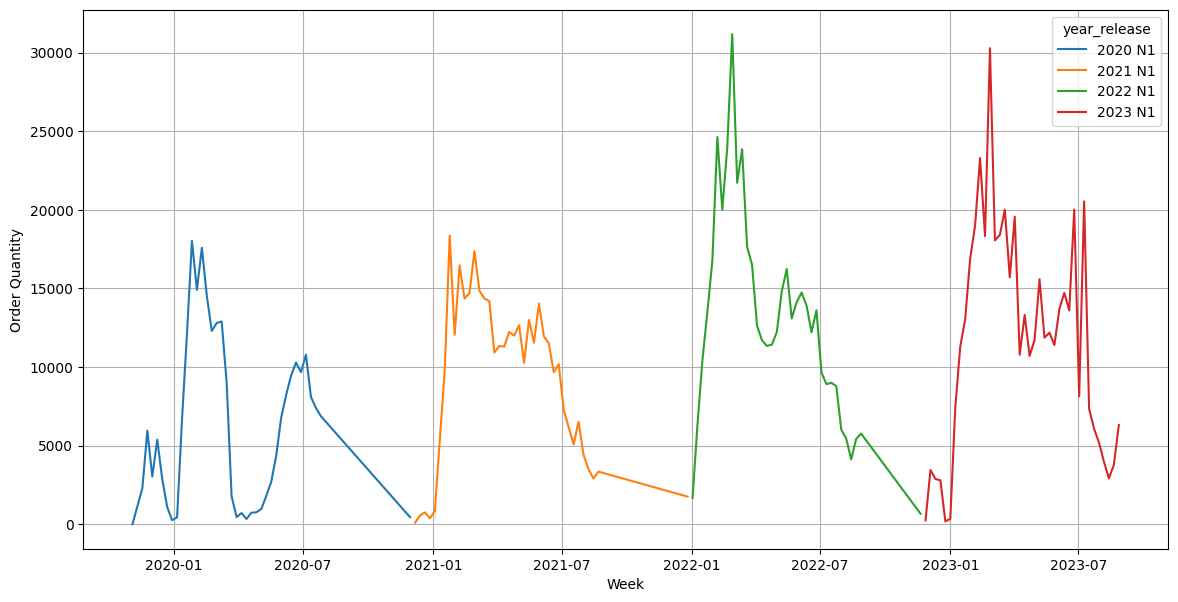

20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/11 [00:00<?, ?it/s]20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 2/11 [00:00<00:00, 16.36it/s]20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 4/11 [00:00<00:00, 16.29it/s]20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▍    | 6/11 [00:00<00:00, 16.40it/s]20:24:28 - cmdstanpy - INFO - Cha

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-12-05,5328.971671,1947.832997,8334.061524,2022.052632,2021-11-28
1,2021-12-12,5254.216982,2022.779662,8467.433728,1933.789474,2021-11-28
2,2021-12-19,4222.761265,872.356638,7386.779742,1845.526316,2021-11-28
3,2021-12-26,3176.214550,-138.971659,6333.149886,1757.263158,2021-11-28
4,2022-01-02,3941.324783,774.101522,7097.494368,1669.000000,2021-11-28
...,...,...,...,...,...,...
83,2022-10-02,7289.335670,3601.582140,10852.491697,3642.000000,2022-09-04
84,2022-10-09,7035.269587,3559.285432,10972.536825,3217.000000,2022-09-04
85,2022-10-16,6571.730433,3338.883594,10307.892456,2792.000000,2022-09-04
86,2022-10-23,6252.490485,2752.522977,9943.197316,2367.000000,2022-09-04


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,8.338277e+06,2887.607535,2413.484806,0.469647,0.257900,0.322692,0.909091
1,14 days,1.086583e+07,3296.335331,2754.271861,0.398303,0.262131,0.291153,0.818182
2,21 days,1.221811e+07,3495.441184,3021.693766,0.459928,0.463621,0.344446,0.636364
3,28 days,1.989652e+07,4460.551489,4052.840375,0.506093,0.460406,0.396630,0.454545
4,35 days,3.160644e+07,5621.960166,4347.851658,0.598052,0.456731,0.433193,0.545455
5,42 days,1.680099e+07,4098.900473,3604.708494,0.447640,0.327251,0.343033,0.454545
6,49 days,2.280987e+07,4775.967480,4257.956579,0.563913,0.421465,0.414907,0.454545
7,56 days,2.622580e+07,5121.113013,4817.563799,0.693011,0.411984,0.477070,0.181818


/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


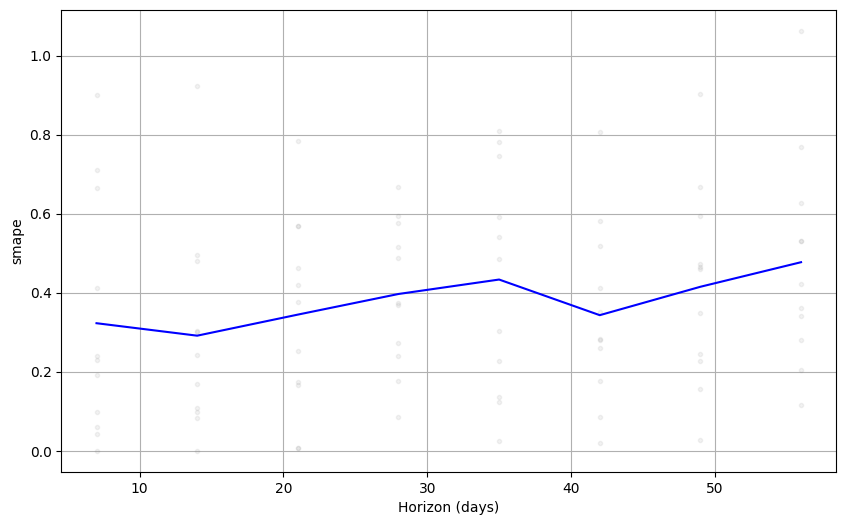

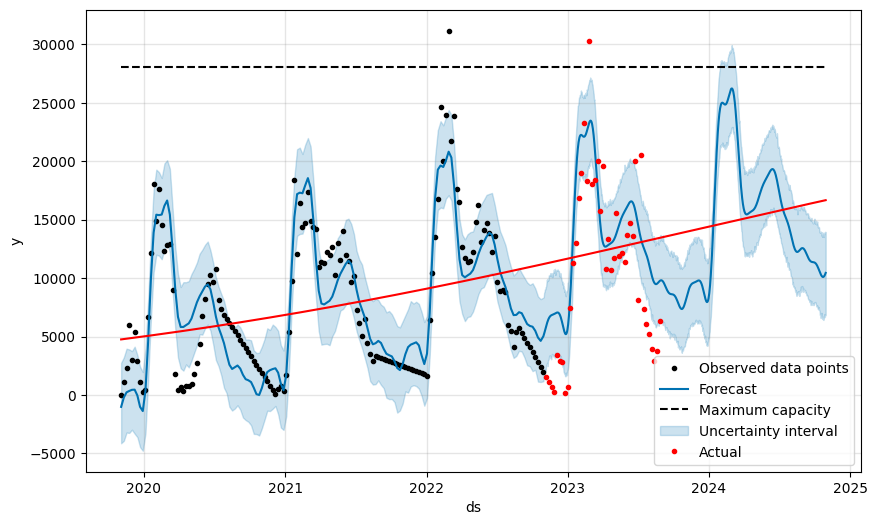

/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/tesi_tommy/.venv/lib/python3.11/site-packages/prophet/plot.py

Mean Absolute Error (MAE): 4043.12
Mean Squared Error (MSE): 19849449.10
Root Mean Squared Error (RMSE): 4455.27
Symmetric Mean Absolute Percentage Error (SMAPE): 52.75%
WMAPE: 37.10%
Total Aboslute Percentage Error: 23.58% 



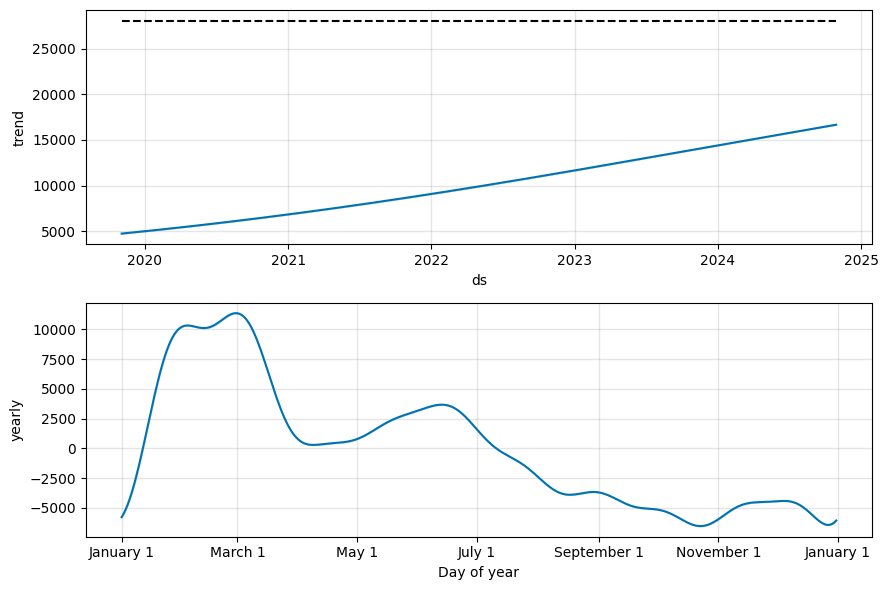

In [135]:
for brand in ['RB','OO','RX','VO','PR','EA','DG']:

    brand = brand
    area = AREA
    release = RELEASE

    print("*"*20)
    print(brand)
    print(area)
    print(release)
    print("*"*20)
    df_trial = df_temp.query("brand == @brand and area_dedalo == @area and release == @release")

    df_trial['year_week'] = df_trial['year_week'].apply(yearweek_to_datetime)

    df_filtered = df_trial[df_trial.apply(filter_dates, axis=1)]

    

    # INTERPOLATION
    display(df_filtered)
    df_filtered = linear_interpolation_for_missing_data(df_filtered)

    display(df_filtered)
    # PLOT
    df_plot = df_filtered.copy()
    # Set the 'year_week' column as the DataFrame index


    df_filtered = df_filtered.groupby(by = 'year_week', as_index=False)['order_quantity'].sum()
    # Now plot the time series


    plt.figure(figsize=(14, 7))
    sns.lineplot(data = df_plot,  x = 'year_week', y = 'order_quantity', hue = 'year_release')
    plt.xlabel('Week')
    plt.ylabel('Order Quantity')
    plt.grid(True)
    plt.show()




    # ADDING EXOGENOUS VARIABLES ----------------
    # saturation of hte market for logistic growth
    cap = df_filtered.order_quantity.max()*0.9  # add a roof for saturation of the market. Set growth='logistic' in Prophet params
    df_filtered['cap'] =  cap # add a roof for saturation of the market

    # luxottica days
    start_year = df_filtered.year_week.dt.year.min()
    lux_days = generate_lux_days_dataframe(start_year=start_year, release=RELEASE)
    #df_filtered = df_filtered.merge(lux_days, how = 'left').fillna(1)

    


    # Split the data into a training set and a testing set
    if RELEASE == 'N1':
        input_date = '2022-10-31'
    elif RELEASE == 'N2':
        input_date = '2022-06-30'

    train_size_list = [x for x in df_filtered.year_week if x <= datetime.strptime(input_date,'%Y-%m-%d')]
    train_size = len(train_size_list)
    train = df_filtered.iloc[:train_size].reset_index(drop=True).rename(columns={'year_week': 'ds', 'order_quantity': 'y'}) # we have to pass to Prohet only two columns named ds and y
    test = df_filtered.iloc[train_size:].reset_index(drop=True).rename(columns={'year_week': 'ds', 'order_quantity': 'y'})

    # INITIALIZATE PROPHET MODEL ---------------------------------------------------------------------------
    model = Prophet(
        growth='logistic',
        #changepoint_prior_scale=0.05, # increase to make the changes of the trend more flexible
        seasonality_mode='additive' # if you think seasonality should be add as a multiplicative factor
    ) 

    # ADDING EXOGENOUS VAR
    #model.add_regressor('lux_days', mode = 'additive')

    # ADDING COUNTRY'S HOLIDAYS IF NEEDED
    if AREA in ['MENA','MUESED','TRAVEL','TRAPAC']:
        country = 'IT'
    elif AREA in ['NORAME','NACOMM']:
        country = 'US'
    #model.add_country_holidays(country_name=country) # add country holidays


    



    # FITTING THE MODEL
    model.fit(train)

    
    # CROSS VALIDATION
    df_cv = cross_validation(model, initial='731 days', period='28 days', horizon = '56 days')  #cross validation

    display(df_cv)

    performance = performance_metrics(df_cv)

    display(performance)

    plot_cross_validation_metric(df_cv, metric='smape')


    # -------------------------------------------------------------------------------------------------------

    # Create a DataFrame with future dates for forecasting based on the testing set
    future = test.drop(columns='y')
    future  = model.make_future_dataframe(periods= (df_filtered.iloc[-1, 0] - train_size_list[-1]).days,  freq='D')  #it contains in-sample and out-sample dates
    future  = model.make_future_dataframe(periods= 730,  freq='D')  #it contains in-sample and out-sample dates
    future['cap'] = cap
    #future=future.merge(lux_days, left_on = 'ds', right_on = 'year_week', how = 'left' ).fillna(1) 
    #future = future.drop(columns='year_week')
    # Make predictions on the testing set dates
    forecast = model.predict(future) #dataframe with a lot of information, yhat=prediction,  

    # Plot the forecast and the actual values
    fig, ax = plt.subplots(figsize=(10, 6))
    model.plot(forecast, ax=ax)
    ax.plot(test['ds'], test['y'], 'r.', label='Actual')
    a = add_changepoints_to_plot(fig.gca(), model, forecast)
    plt.legend()
    plt.show()

    model.plot_components(forecast)



    # Calculate performance metrics
    test = test.merge(forecast[['ds', 'yhat']], on = 'ds', how = 'left')
    test = test.rename(columns={'yhat': 'forecast'})
    mae = mean_absolute_error(test['y'], test['forecast'])
    mse = mean_squared_error(test['y'], test['forecast'])
    rmse = sqrt(mse)
    wmape_val = wmape(test['y'], test['forecast'])
    smape_value = smape(test['y'], test['forecast'])

    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape_value:.2f}%')
    print(f'WMAPE: {wmape_val:.2f}%')
    print(f'Total Aboslute Percentage Error: {((test.forecast.sum() - test.y.sum())/test.y.sum())*100:.2f}% ')

    print()

    break

In [132]:
df_filtered

,year_week,order_quantity,cap
0,2019-11-03,1.0,28052.1
1,2019-11-10,1151.5,28052.1
2,2019-11-17,2302.0,28052.1
3,2019-11-24,5953.0,28052.1
4,2019-12-01,3034.0,28052.1
...,...,...,...
195,2023-07-30,5193.0,28052.1
196,2023-08-06,3972.0,28052.1
197,2023-08-13,2920.0,28052.1
198,2023-08-20,3787.0,28052.1


In [133]:
df_plot

,year_week,exit,brand,area_dedalo,year_release,order_quantity,release
0,2019-11-03,201910,RB,MUESED,2020 N1,1.0,N1
1,2019-11-10,201910,RB,MUESED,2020 N1,1151.5,N1
2,2019-11-17,201910,RB,MUESED,2020 N1,2302.0,N1
3,2019-11-24,201910,RB,MUESED,2020 N1,5953.0,N1
4,2019-12-01,201910,RB,MUESED,2020 N1,3034.0,N1
...,...,...,...,...,...,...,...
197,2023-07-30,202301,RB,MUESED,2023 N1,5193.0,N1
198,2023-08-06,202301,RB,MUESED,2023 N1,3972.0,N1
199,2023-08-13,202301,RB,MUESED,2023 N1,2920.0,N1
200,2023-08-20,202301,RB,MUESED,2023 N1,3787.0,N1


In [134]:

def linear_interpolation_for_missing_data(df_filtered)
    # Create a complete range of weeks from the start to the end of the original data
    all_weeks_complete = pd.date_range(start=df_filtered['year_week'].min(), end=df_filtered['year_week'].max(), freq='W-SUN')

    # Create a new dataframe with all weeks
    df_full = pd.DataFrame(all_weeks_complete, columns=['year_week'])

    # Merge the original data with the full dataframe
    # This will result in NaNs where the original data is missing
    df_merged = df_full.merge(df_filtered, on='year_week', how='left')

    # Interpolate to fill missing values
    df_merged['order_quantity'] = df_merged['order_quantity'].interpolate(method='linear')

    # Displaying the first few rows of the filled dataframe
    df_filled = df_merged[['year_week', 'order_quantity']]

    return df_filled

SyntaxError: expected ':' (34862048.py, line 1)

In [ ]:
df_filled

,year_week,order_quantity
0,2019-11-03,1.0
1,2019-11-10,1151.5
2,2019-11-17,2302.0
3,2019-11-24,5953.0
4,2019-12-01,3034.0
...,...,...
195,2023-07-30,5193.0
196,2023-08-06,3972.0
197,2023-08-13,2920.0
198,2023-08-20,3787.0


In [ ]:
df_filtered

,year_week,order_quantity,cap
0,2019-11-03,1,28052.1
1,2019-11-17,2302,28052.1
2,2019-11-24,5953,28052.1
3,2019-12-01,3034,28052.1
4,2019-12-08,5383,28052.1
...,...,...,...
146,2023-07-30,5193,28052.1
147,2023-08-06,3972,28052.1
148,2023-08-13,2920,28052.1
149,2023-08-20,3787,28052.1
